# Data Preparation

### Loading Packages and Functions

In [86]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# also install necessary dependencies of the excel plugin of pandas

In [2]:
# function to move a column to a new position
def move_column(df, col_name, new_position):
    temp_col = df[col_name]
    df = df.drop(columns=[col_name])
    df.insert(new_position, col_name, temp_col)
    return df

In [66]:
def convert_to_numeric(df):
    for col in df.columns:
        # Attempt to convert the column to numeric, setting errors='ignore' keeps the original data if conversion fails
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

## Data: "A dataset of images and morphological profiles of 30,000 small-molecule treatments using the Cell Painting assay"

The Cell Image Library has a “Human U2OS Cell: Compound Cell-Painting Experiment” project data that contains the images of 375 plates in 384-well format (More details: https://www.cellimagelibrary.org/pages/project_20269): 

- The images are of U2OS cells treated with each of over 30,000 known bioactive compounds.
- These cells are labeled with 6 labels that characterize seven organelles (the cell-painting assay).
- The data set is comprised of 988,994 fields of view.
- Each field was imaged in five channels (detection wavelengths), and each channel is stored as a separate, grayscale image file.
- As a result, there are approximately 5 million image files in 16-bit TIFF format.

Bray et al. (2017)’s research uses the raw image data of, and includes highly multiplexed measurements of cellular morphology of the tested compounds from the above Human U2OS Cell research. It includes:

- data files containing morphological features derived from each cell in each image (both at the single-cell level and population-averaged, i.e. per-well level),
- the image analysis workflows that generated the morphological features,
- quality-control metrics are provided as metadata,
- chemical annotations for the applied compound treatments.

- Description and files: http://gigadb.org/dataset/view/id/100351/Files_page/1
- Codebase: https://github.com/gigascience/paper-bray2017/tree/master


### Connecting to the SQLite Database

In [3]:
# path to the .sqlite file
db_path = '../Data/Bray et al. 2017 GigaScience/Plate_24278/extracted_features/24278.sqlite'

conn = sql.connect(db_path) # connect to the SQLite database
cursor = conn.cursor() # create a cursor object to execute SQL queries

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") # cursor execution for retrieving the list of all tables
dbTables = cursor.fetchall() # fetch the command output in a list object

# view the list of tables
dbTables_temp = []
print("Tables in the sqlite database:")
for table in dbTables:
    print(table[0])
    dbTables_temp.append(table[0])
dbTables = dbTables_temp

Tables in the sqlite database:
Image
Nuclei
Cytoplasm
Cells


### Columns of the SQLite Tables

In [4]:
# retrieve all table columns and put them in a dictionary
tableColumns = {}
for table in dbTables:
    cursor.execute(f"PRAGMA table_info({table});") # cursor call for retrieving table information
    cursor_output = cursor.fetchall() # cursor fetch operation to retrieve the SQL command output
    columns = [col[1] for col in cursor_output]
    tableColumns[table] = columns

for table in tableColumns:
    print(f'{table}: {len(tableColumns[table])} Columns')
    print(f'{table}: {tableColumns[table]} Columns\n')

Image: 636 Columns
Image: ['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21

### Size of the Database Tables

As it can be seen from the table sizes, the cell-specific tables (besides the image table) are too large to load into a dataframe.

In [5]:
for table in dbTables:

    cursor.execute(f"SELECT COUNT(*) FROM {table};") # cursor call for executing SQL command 
    row_count = cursor.fetchone()[0] # fetch the first element of the cursor call output
    
    cursor.execute(f"PRAGMA table_info({table});") # cursor command for retrieving column information
    column_count = len(cursor.fetchall())
    
    # print the dimension and size information of each table
    print(f"{table} | Rows: {row_count} | Columns: {column_count} | Datapoints: {(row_count * column_count / 1000000):.1f}M")

Image | Rows: 2282 | Columns: 636 | Datapoints: 1.5M
Nuclei | Rows: 219193 | Columns: 608 | Datapoints: 133.3M
Cytoplasm | Rows: 219193 | Columns: 585 | Datapoints: 128.2M
Cells | Rows: 219193 | Columns: 599 | Datapoints: 131.3M


### Loading Dataframes

In [6]:
# select a subset of columns and create a separate column dictionary
dfColumns = {}

dfColumns['Image'] = ['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21SaveImages', 'Image_FileName_CellOutlines', 'Image_FileName_IllumAGP', 'Image_FileName_IllumDNA', 'Image_FileName_IllumER', 'Image_FileName_IllumMito', 'Image_FileName_IllumRNA', 'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA']
dfColumns['Nuclei'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Nuclei_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_Eccentricity', 'Nuclei_AreaShape_EulerNumber', 'Nuclei_AreaShape_Extent', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_MajorAxisLength', 'Nuclei_AreaShape_MaxFeretDiameter', 'Nuclei_AreaShape_MaximumRadius', 'Nuclei_AreaShape_MeanRadius', 'Nuclei_AreaShape_MedianRadius', 'Nuclei_AreaShape_MinFeretDiameter', 'Nuclei_AreaShape_MinorAxisLength', 'Nuclei_AreaShape_Orientation', 'Nuclei_AreaShape_Perimeter', 'Nuclei_AreaShape_Solidity']
dfColumns['Cytoplasm'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cytoplasm_AreaShape_Area', 'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y', 'Cytoplasm_AreaShape_Compactness', 'Cytoplasm_AreaShape_Eccentricity', 'Cytoplasm_AreaShape_EulerNumber', 'Cytoplasm_AreaShape_Extent', 'Cytoplasm_AreaShape_FormFactor', 'Cytoplasm_AreaShape_MajorAxisLength', 'Cytoplasm_AreaShape_MaxFeretDiameter', 'Cytoplasm_AreaShape_MaximumRadius', 'Cytoplasm_AreaShape_MeanRadius', 'Cytoplasm_AreaShape_MedianRadius', 'Cytoplasm_AreaShape_MinFeretDiameter', 'Cytoplasm_AreaShape_MinorAxisLength', 'Cytoplasm_AreaShape_Orientation', 'Cytoplasm_AreaShape_Perimeter', 'Cytoplasm_AreaShape_Solidity']
dfColumns['Cells'] = ['TableNumber', 'ImageNumber', 'ObjectNumber', 'Cells_AreaShape_Area', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent', 'Cells_AreaShape_FormFactor', 'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MaxFeretDiameter', 'Cells_AreaShape_MaximumRadius', 'Cells_AreaShape_MeanRadius', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinFeretDiameter', 'Cells_AreaShape_MinorAxisLength', 'Cells_AreaShape_Orientation', 'Cells_AreaShape_Perimeter', 'Cells_AreaShape_Solidity']

for df in dfColumns:
    print(f'{df}: {len(dfColumns[df])} Columns')

dfColumns

Image: 36 Columns
Nuclei: 21 Columns
Cytoplasm: 21 Columns
Cells: 21 Columns


{'Image': ['TableNumber',
  'Image_Count_Cells',
  'Image_Count_Cytoplasm',
  'Image_Count_Nuclei',
  'Image_ExecutionTime_01LoadData',
  'Image_ExecutionTime_02CorrectIlluminationApply',
  'Image_ExecutionTime_03MeasureImageQuality',
  'Image_ExecutionTime_04MeasureImageQuality',
  'Image_ExecutionTime_06IdentifyPrimaryObjects',
  'Image_ExecutionTime_07IdentifySecondaryObjects',
  'Image_ExecutionTime_08IdentifyTertiaryObjects',
  'Image_ExecutionTime_09MeasureCorrelation',
  'Image_ExecutionTime_10MeasureGranularity',
  'Image_ExecutionTime_11MeasureObjectIntensity',
  'Image_ExecutionTime_12MeasureObjectNeighbors',
  'Image_ExecutionTime_13MeasureObjectNeighbors',
  'Image_ExecutionTime_14MeasureObjectNeighbors',
  'Image_ExecutionTime_15MeasureObjectIntensityDistribution',
  'Image_ExecutionTime_16MeasureObjectSizeShape',
  'Image_ExecutionTime_17MeasureTexture',
  'Image_ExecutionTime_18OverlayOutlines',
  'Image_ExecutionTime_19OverlayOutlines',
  'Image_ExecutionTime_20SaveImag

In [7]:
tableDataframes = {} # create a blank dictionary to save each table as a dataframe, with a table_name key

for table in dbTables: # loop through all tables 
    
    query = f"SELECT {', '.join(dfColumns[table])} FROM {table};"  # set up the query using parameters
    df = pd.read_sql_query(query, conn) # use the open connector to pull table into

    tableDataframes[table] = df # store the sample df in the dictionary
    print(f"Table {table} has been saved.")

Table Image has been saved.
Table Nuclei has been saved.
Table Cytoplasm has been saved.
Table Cells has been saved.


In [8]:
# check the datapoint amount of reduced sub-tables
# Image | Rows: 2282 | Columns: 636 | Count: 1.5M
for table in dbTables:
    row_count = tableDataframes[table].shape[0]
    col_count = tableDataframes[table].shape[1]
    print(f'{table} | Rows: {row_count} | Columns: {col_count} | Datapoints: {(row_count * col_count / 1000000):.1f}M')

Image | Rows: 2282 | Columns: 36 | Datapoints: 0.1M
Nuclei | Rows: 219193 | Columns: 21 | Datapoints: 4.6M
Cytoplasm | Rows: 219193 | Columns: 21 | Datapoints: 4.6M
Cells | Rows: 219193 | Columns: 21 | Datapoints: 4.6M


### Processing Dataframes

In [9]:
# Check each dataframe if they have any columns with the phrase 'FileName'
for table in dbTables:
    phrase = 'FileName'
    print([col for col in tableDataframes[table].columns if phrase in col])

['Image_FileName_CellOutlines', 'Image_FileName_IllumAGP', 'Image_FileName_IllumDNA', 'Image_FileName_IllumER', 'Image_FileName_IllumMito', 'Image_FileName_IllumRNA', 'Image_FileName_NucleiOutlines', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA']
[]
[]
[]


In [10]:
# Split the FileName column into well information and picture number
tableDataframes['Image']['WellID'] = tableDataframes['Image']['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[0]
tableDataframes['Image']['FieldID'] = tableDataframes['Image']['Image_FileName_CellOutlines'].str.split('--').str[0].str.split('_').str[1]

# fix the order of the newly added columns
tableDataframes['Image'] = move_column(tableDataframes['Image'], 'WellID', 1)
tableDataframes['Image'] = move_column(tableDataframes['Image'], 'FieldID', 2)

# view a snippet to check the new columns
tableDataframes['Image'].head(3)

,TableNumber,WellID,FieldID,Image_Count_Cells,Image_Count_Cytoplasm,Image_Count_Nuclei,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02CorrectIlluminationApply,Image_ExecutionTime_03MeasureImageQuality,Image_ExecutionTime_04MeasureImageQuality,...,Image_FileName_IllumDNA,Image_FileName_IllumER,Image_FileName_IllumMito,Image_FileName_IllumRNA,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA
0,0702991209138712afb02ac7ea637f71,a01,s1,58.0,58.0,58.0,4.33,0.05,6.79,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s1--nuclei_outlines.png,cdp2bioactives_a01_s1_w46d2c0547-8e3b-440e-a85...,cdp2bioactives_a01_s1_w1bfb15712-b306-40fd-a77...,cdp2bioactives_a01_s1_w2edcec6dc-b1e3-4ffc-80d...,cdp2bioactives_a01_s1_w5d4e4b98c-0f39-4db9-91b...,cdp2bioactives_a01_s1_w336f7b0bc-6ae8-4667-a6a...
1,e2238b50acc3114c310acbf4c68bd114,a01,s2,35.0,35.0,35.0,4.29,0.03,5.95,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s2--nuclei_outlines.png,cdp2bioactives_a01_s2_w4da2481a5-d23f-4aae-b35...,cdp2bioactives_a01_s2_w1bd0b9bc7-0d8b-48ed-b04...,cdp2bioactives_a01_s2_w2abeb5a62-b570-447f-97f...,cdp2bioactives_a01_s2_w57540fec0-d693-46a8-bd6...,cdp2bioactives_a01_s2_w3b3fb2060-153d-4096-af5...
2,b983ac6d8cc9a5ed9b713585e32ac4ae,a01,s3,26.0,26.0,26.0,4.35,0.03,5.30,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s3--nuclei_outlines.png,cdp2bioactives_a01_s3_w48ffcfde9-24ae-486c-844...,cdp2bioactives_a01_s3_w17290b03d-9255-40d6-898...,cdp2bioactives_a01_s3_w268c116dd-b84b-4a22-94d...,cdp2bioactives_a01_s3_w5b3744705-89fc-4e6e-9c7...,cdp2bioactives_a01_s3_w3334a07f0-46b6-4e3d-8d8...


In [11]:
# change TableNumber to tableID in all of the tables
for table in dbTables:
    tableDataframes[table].rename(columns={'TableNumber': 'TableID'}, inplace=True)

In [12]:
# adding well ID and field ID to other tables
for table in ['Cells', 'Cytoplasm', 'Nuclei']:
    tableDataframes[table] = tableDataframes[table].merge(tableDataframes['Image'][['TableID', 'WellID', 'FieldID']], on='TableID', how='left')
    tableDataframes[table] = move_column(tableDataframes[table], 'WellID', 1)
    tableDataframes[table] = move_column(tableDataframes[table], 'FieldID', 2)

In [87]:
# convert all numeric columns to float
for table in ['Cells', 'Cytoplasm', 'Nuclei']:
    for eachColumn in tableDataframes[table].columns:
        if 'AreaShape' in eachColumn:
            try:
                # replace 'nan' strings with np.nan
                tableDataframes[table][eachColumn] = tableDataframes[table][eachColumn].replace('nan', np.nan)
                # attempt to convert the column to numeric type
                tableDataframes[table][eachColumn] = pd.to_numeric(tableDataframes[table][eachColumn])
                # print(f"Converted column '{eachColumn}' in table '{table}' to numeric.")
            except ValueError:
                # if conversion fails, leave the column unchanged
                print(f"Could not convert column '{eachColumn}' in table '{table}'. Leaving it unchanged.")

/var/folders/vr/dsp7vw_n6rn1hrtlct_1zg9w0000gn/T/ipykernel_53171/2639242965.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tableDataframes[table][eachColumn] = tableDataframes[table][eachColumn].replace('nan', np.nan)


### (Optional) Exporting Dataframes as CSV

In [13]:
# set up the query parameters
# table_name = 'Image'
row_limit = 3

for table in dbTables:
    print(f"\n{table}")

    cursor.execute(f"PRAGMA table_info({table});") # cursor call for retrieving table information
    columns = cursor.fetchall()
    column_names = [col[1] for col in columns]
    print(column_names)

    query = f"SELECT * FROM {table} LIMIT {row_limit};"  # set up the query using parameters
    cursor.execute(query) # execute the cursor call using the query
    rows = cursor.fetchall() # fetch the output of the cursor
    for row in rows:
        print(row)


Image
['TableNumber', 'Image_Count_Cells', 'Image_Count_Cytoplasm', 'Image_Count_Nuclei', 'Image_ExecutionTime_01LoadData', 'Image_ExecutionTime_02CorrectIlluminationApply', 'Image_ExecutionTime_03MeasureImageQuality', 'Image_ExecutionTime_04MeasureImageQuality', 'Image_ExecutionTime_06IdentifyPrimaryObjects', 'Image_ExecutionTime_07IdentifySecondaryObjects', 'Image_ExecutionTime_08IdentifyTertiaryObjects', 'Image_ExecutionTime_09MeasureCorrelation', 'Image_ExecutionTime_10MeasureGranularity', 'Image_ExecutionTime_11MeasureObjectIntensity', 'Image_ExecutionTime_12MeasureObjectNeighbors', 'Image_ExecutionTime_13MeasureObjectNeighbors', 'Image_ExecutionTime_14MeasureObjectNeighbors', 'Image_ExecutionTime_15MeasureObjectIntensityDistribution', 'Image_ExecutionTime_16MeasureObjectSizeShape', 'Image_ExecutionTime_17MeasureTexture', 'Image_ExecutionTime_18OverlayOutlines', 'Image_ExecutionTime_19OverlayOutlines', 'Image_ExecutionTime_20SaveImages', 'Image_ExecutionTime_21SaveImages', 'Image

In [14]:
sampleDataframes = {} # create a blank dictionary to save each table as a dataframe, with a table_name key
row_limit = 10

for table in dbTables: # loop through all tables 
    
    query = f"SELECT * FROM {table} LIMIT {row_limit};"  # set up the query using parameters
    df = pd.read_sql_query(query, conn) # use the open connector to pull table into

    sampleDataframes[table] = df # store the sample df in the dictionary
    print(f"Table {table} has been saved.")

Table Image has been saved.
Table Nuclei has been saved.
Table Cytoplasm has been saved.
Table Cells has been saved.


In [15]:
for table_name, df in sampleDataframes.items():
    # Export each DataFrame to a CSV file
    df.to_csv(f"{table_name}.csv", index=False)  # index=False avoids writing row numbers
    print(f"Exported {table_name} to {table_name}.csv")


Exported Image to Image.csv
Exported Nuclei to Nuclei.csv
Exported Cytoplasm to Cytoplasm.csv
Exported Cells to Cells.csv


In [16]:
# close the connection when the sqlite database processing is done
conn.close()

## Data: Ola's Biomorph & Cell Painting Dataset Link

Ola linked the compounds identified in the BioMorph study with the metadata of the Cell Painting dataset. She linked 603 compounds, which results in 5025 wells spread over 94 different plates.
- CPD_NAME: specific compounds
- Metadata_Plate: specific plates
- Metadata_Well: specific wells

### Endpoint Definitions:

#### 1. Apoptosis Up:
- Apoptosis is the process of programmed cell death, where cells die in a controlled manner as part of normal development or in response to damage.
- "**Apoptosis up**" means an increase in the rate of apoptosis in response to a compound, suggesting the compound is inducing cell death via the apoptotic pathway. This could be important in cancer treatments, where the goal is to promote the death of harmful cells.
#### 2. Cytotoxicity BLA:
- Cytotoxicity refers to the toxic effect a compound has on cells, leading to cell damage or death.
- BLA stands for Beta-Lactamase assay, a biochemical assay often used to detect cytotoxicity. The "**Cytotoxicity BLA**" endpoint indicates cell death or damage measured through the Beta-Lactamase assay.
#### 3. Cytotoxicity SRB:
- Similar to Cytotoxicity BLA, this measures cell toxicity, but using a different assay.
- SRB stands for Sulforhodamine B, a dye that binds to cellular proteins, and it’s commonly used to measure cell density and viability. The "**Cytotoxicity SRB**" endpoint measures the cytotoxic effect of compounds based on the amount of protein-bound SRB dye, indicating cell death or reduced viability.
#### 4. ER Stress:
- ER stress refers to stress in the Endoplasmic Reticulum (ER), a cell organelle involved in protein folding and secretion. When misfolded proteins accumulate, ER stress triggers the Unfolded Protein Response (UPR).
- The "ER stress" endpoint indicates that a compound is causing stress in the ER, potentially leading to apoptosis or other cellular dysfunctions.
#### 5. Heat Shock:
- Heat shock refers to the stress response of cells to elevated temperatures, which results in the production of heat shock proteins (HSPs) that help protect cells from damage.
- The "Heat Shock" endpoint suggests the compound is inducing a cellular response similar to what happens when cells are exposed to heat or other stresses, typically leading to the production of HSPs.
#### 6. Microtubule Up:
- Microtubules are part of the cell's cytoskeleton and are crucial for cell division and intracellular transport.
- "Microtubule up" indicates an increase in microtubule stabilization or polymerization due to the compound. Compounds that affect microtubules can disrupt cell division, making this endpoint important in cancer research (e.g., chemotherapy drugs like taxanes target microtubules).
#### 7. Mitochondrial Disruption Up:
- Mitochondria are the energy-producing organelles in cells, and mitochondrial disruption can lead to cell death or dysfunction.
- "Mitochondrial disruption up" indicates an increase in mitochondrial dysfunction, which can lead to cellular energy depletion and apoptosis. This endpoint is used to measure the impact of a compound on mitochondrial health.
#### 8. Oxidative Stress Up:
- Oxidative stress occurs when there is an imbalance between the production of reactive oxygen species (ROS) and the cell’s ability to detoxify them, leading to cellular damage.
- "Oxidative stress up" means the compound is causing an increase in oxidative stress, which can damage DNA, proteins, and lipids, potentially leading to cell death.
#### 9. Proliferation Decrease:
- Proliferation refers to the growth and division of cells. A decrease in proliferation means that the cells are dividing more slowly or not at all.
- "Proliferation decrease" indicates that the compound is inhibiting cell growth. This endpoint is often used in cancer research to evaluate the efficacy of treatments designed to slow or stop the growth of tumor cells.

### Loading the Dataframe

In [17]:
# read the xlsx file
ola_biomorph = pd.read_excel("../Data/Ola/603_compounds_metadata.xlsx")

In [18]:
# understand the general size of the dataset
ola_biomorph.shape

(5025, 23)

In [19]:
# view a snippet of the original dataset
ola_biomorph.head()

,Metadata_broad_sample,Metadata_Plate,Metadata_Well,CPD_NAME,CPD_NAME_TYPE,CPD_SAMPLE_ID,DOS_LIBRARY,SOURCE_NAME,CHEMIST_NAME,VENDOR_CATALOG_ID,...,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease,canonical_smiles
0,BRD-K18619710-001-03-7,24277,a06,digoxigenin,primary-common,SA83657,NaN,Prestwick Chemical Inc.,NaN,Prestw-883,...,0,0,0,1,0,0,0,1,0,C[C@]12CC[C@H](O)C[C@H]1CC[C@@H]1[C@@H]2C[C@@H...
1,BRD-K18779551-003-03-7,24277,a09,bifemelane,primary-common,SA792138,NaN,Tocris Bioscience,NaN,767,...,0,1,0,0,0,0,0,0,0,CNCCCCOc1ccccc1Cc1ccccc1
2,BRD-K18910433-001-04-4,24277,a16,estradiol,INN,SA82244,NaN,Biomol International Inc.,NaN,BL-093,...,1,0,1,1,0,1,0,1,1,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...
3,BRD-K19040732-300-01-9,24277,a18,ftorpropazine,common,SA39571,NaN,ChemBridge Corporation,NaN,5216181,...,1,0,0,0,0,0,0,0,0,O=C(CCN1CCN(CCO)CC1)N1c2ccccc2Sc2ccc(C(F)(F)F)...
4,BRD-K19111024-001-04-3,24277,a19,clofibric acid,INN,SA58236,NaN,MicroSource Discovery Systems Inc.,NaN,1500195,...,0,0,0,0,0,0,0,0,0,CC(C)(Oc1ccc(Cl)cc1)C(=O)O


### Cleaning the Dataframe

In [37]:
# choose the important columns
biomorph_columns = ['Metadata_Plate',	
                    'Metadata_Well',	
                    'CPD_NAME',	'CPD_SAMPLE_ID',	
                    'apoptosis up',	
                    'cytotoxicity BLA',
                    'cytotoxicity SRB',	
                    'ER stress',	
                    'heat shock',	
                    'microtubule up',	
                    'mitochondrial disruption up',	
                    'oxidative stress up', 
                    'proliferation decrease']

# list of toxicity endpoints
endpoint_columns = ['apoptosis up', 'cytotoxicity BLA', 'cytotoxicity SRB', 'ER stress', 
                    'heat shock', 'microtubule up', 'mitochondrial disruption up', 
                    'oxidative stress up', 'proliferation decrease']

# remove the unnecessary columns
biomorph = ola_biomorph.loc[:, biomorph_columns]

# improve the column names
biomorph.rename(columns={'Metadata_Plate': 'PlateID'}, inplace=True)
biomorph.rename(columns={'Metadata_Well': 'WellID'}, inplace=True)

# print the snippet of the cleaned dataset
biomorph.head(10)

,PlateID,WellID,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease
0,24277,a06,digoxigenin,SA83657,0,0,0,1,0,0,0,1,0
1,24277,a09,bifemelane,SA792138,0,1,0,0,0,0,0,0,0
2,24277,a16,estradiol,SA82244,1,0,1,1,0,1,0,1,1
3,24277,a18,ftorpropazine,SA39571,1,0,0,0,0,0,0,0,0
4,24277,a19,clofibric acid,SA58236,0,0,0,0,0,0,0,0,0
5,24277,a20,gossypol,SA58982,1,1,0,1,1,0,0,0,0
6,24277,b02,megestrol acetate,SA83664,0,1,0,0,0,0,1,0,0
7,24277,b19,riluzole,SA82545,1,0,0,0,0,0,0,0,0
8,24277,b21,benzthiazide,SA58195,0,0,0,0,0,0,0,0,0
9,24277,b22,sulfacetamide,SA58897,0,0,0,0,0,0,0,0,0


In [21]:
biomorph.shape

(5025, 13)

In [38]:
# take a look at the 
biomorph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PlateID                      5025 non-null   int64 
 1   WellID                       5025 non-null   object
 2   CPD_NAME                     5025 non-null   object
 3   CPD_SAMPLE_ID                5025 non-null   object
 4   apoptosis up                 5025 non-null   int64 
 5   cytotoxicity BLA             5025 non-null   int64 
 6   cytotoxicity SRB             5025 non-null   int64 
 7   ER stress                    5025 non-null   int64 
 8   heat shock                   5025 non-null   int64 
 9   microtubule up               5025 non-null   int64 
 10  mitochondrial disruption up  5025 non-null   int64 
 11  oxidative stress up          5025 non-null   int64 
 12  proliferation decrease       5025 non-null   int64 
dtypes: int64(10), object(3)
memory us

# Explatory Data Analysis

## Table Snippets

In [88]:
print(tableDataframes['Image'].info())
tableDataframes['Image'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 38 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   TableID                                                   2282 non-null   object 
 1   WellID                                                    2282 non-null   object 
 2   FieldID                                                   2282 non-null   object 
 3   Image_Count_Cells                                         2282 non-null   float64
 4   Image_Count_Cytoplasm                                     2282 non-null   float64
 5   Image_Count_Nuclei                                        2282 non-null   float64
 6   Image_ExecutionTime_01LoadData                            2282 non-null   float64
 7   Image_ExecutionTime_02CorrectIlluminationApply            2282 non-null   float64
 8   Image_ExecutionTim

,TableID,WellID,FieldID,Image_Count_Cells,Image_Count_Cytoplasm,Image_Count_Nuclei,Image_ExecutionTime_01LoadData,Image_ExecutionTime_02CorrectIlluminationApply,Image_ExecutionTime_03MeasureImageQuality,Image_ExecutionTime_04MeasureImageQuality,...,Image_FileName_IllumDNA,Image_FileName_IllumER,Image_FileName_IllumMito,Image_FileName_IllumRNA,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA
0,0702991209138712afb02ac7ea637f71,a01,s1,58.0,58.0,58.0,4.33,0.05,6.79,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s1--nuclei_outlines.png,cdp2bioactives_a01_s1_w46d2c0547-8e3b-440e-a85...,cdp2bioactives_a01_s1_w1bfb15712-b306-40fd-a77...,cdp2bioactives_a01_s1_w2edcec6dc-b1e3-4ffc-80d...,cdp2bioactives_a01_s1_w5d4e4b98c-0f39-4db9-91b...,cdp2bioactives_a01_s1_w336f7b0bc-6ae8-4667-a6a...
1,e2238b50acc3114c310acbf4c68bd114,a01,s2,35.0,35.0,35.0,4.29,0.03,5.95,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s2--nuclei_outlines.png,cdp2bioactives_a01_s2_w4da2481a5-d23f-4aae-b35...,cdp2bioactives_a01_s2_w1bd0b9bc7-0d8b-48ed-b04...,cdp2bioactives_a01_s2_w2abeb5a62-b570-447f-97f...,cdp2bioactives_a01_s2_w57540fec0-d693-46a8-bd6...,cdp2bioactives_a01_s2_w3b3fb2060-153d-4096-af5...
2,b983ac6d8cc9a5ed9b713585e32ac4ae,a01,s3,26.0,26.0,26.0,4.35,0.03,5.30,0.11,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s3--nuclei_outlines.png,cdp2bioactives_a01_s3_w48ffcfde9-24ae-486c-844...,cdp2bioactives_a01_s3_w17290b03d-9255-40d6-898...,cdp2bioactives_a01_s3_w268c116dd-b84b-4a22-94d...,cdp2bioactives_a01_s3_w5b3744705-89fc-4e6e-9c7...,cdp2bioactives_a01_s3_w3334a07f0-46b6-4e3d-8d8...
3,726ad7ac7c4813097cc3aab610c143b4,a01,s4,55.0,55.0,55.0,4.70,0.04,6.84,0.12,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s4--nuclei_outlines.png,cdp2bioactives_a01_s4_w46dbd1f1e-f3cd-4590-ba2...,cdp2bioactives_a01_s4_w1d07860e9-2432-4233-96b...,cdp2bioactives_a01_s4_w2a8a9c55a-b3b7-4f4d-b70...,cdp2bioactives_a01_s4_w5752fd3e8-0997-4cf1-8a8...,cdp2bioactives_a01_s4_w3e9947106-9c5d-428a-b8a...
4,9a0fed6eaf4ee63b89adc60e02bfbb58,a01,s5,21.0,21.0,21.0,4.25,0.03,6.44,0.08,...,24278_IllumDNA.mat,24278_IllumER.mat,24278_IllumMito.mat,24278_IllumRNA.mat,a01_s5--nuclei_outlines.png,cdp2bioactives_a01_s5_w41bba91bb-81ff-4862-af3...,cdp2bioactives_a01_s5_w1ac6937d8-cbbe-40d4-899...,cdp2bioactives_a01_s5_w20f38032f-7e71-41cc-94c...,cdp2bioactives_a01_s5_w518bc5494-c49b-4c7f-a94...,cdp2bioactives_a01_s5_w373e8a6f0-ac34-4be4-8b1...


In [89]:
print(tableDataframes['Cells'].info())
tableDataframes['Cells'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219193 entries, 0 to 219192
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   TableID                           219193 non-null  object 
 1   WellID                            219193 non-null  object 
 2   FieldID                           219193 non-null  object 
 3   ImageNumber                       219193 non-null  int64  
 4   ObjectNumber                      219193 non-null  int64  
 5   Cells_AreaShape_Area              219193 non-null  int64  
 6   Cells_AreaShape_Center_X          219193 non-null  float64
 7   Cells_AreaShape_Center_Y          219193 non-null  float64
 8   Cells_AreaShape_Compactness       219179 non-null  float64
 9   Cells_AreaShape_Eccentricity      219179 non-null  float64
 10  Cells_AreaShape_EulerNumber       219193 non-null  float64
 11  Cells_AreaShape_Extent            219193 non-null  f

,TableID,WellID,FieldID,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinFeretDiameter,Cells_AreaShape_MinorAxisLength,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,Cells_AreaShape_Solidity
0,0702991209138712afb02ac7ea637f71,a01,s1,1,1,1634,43.0,0.0,1.509013,0.857468,...,70.397234,80.709355,21.023796,7.075857,6.082763,40.703919,36.222035,63.738571,230.324,0.836447
1,0702991209138712afb02ac7ea637f71,a01,s1,1,2,2999,619.0,28.0,1.487299,0.899966,...,97.565456,112.507778,20.000000,7.415620,6.708204,51.680329,42.534725,-34.521891,327.642,0.796441
2,0702991209138712afb02ac7ea637f71,a01,s1,1,3,2471,219.0,33.0,1.126171,0.694497,...,68.268046,70.710678,20.615528,7.682926,7.000000,51.342921,49.118568,-73.795204,243.636,0.853099
3,0702991209138712afb02ac7ea637f71,a01,s1,1,4,1951,265.0,32.0,1.383061,0.887278,...,75.198694,81.492331,17.691806,6.372729,5.830952,37.103120,34.684289,-28.019719,217.738,0.913390
4,0702991209138712afb02ac7ea637f71,a01,s1,1,5,1619,82.0,11.0,1.119820,0.669052,...,54.504681,58.591808,18.681542,7.630574,7.000000,41.751358,40.508727,-70.130892,187.254,0.893241


In [90]:
print(tableDataframes['Nuclei'].info())
tableDataframes['Nuclei'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219193 entries, 0 to 219192
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   TableID                            219193 non-null  object 
 1   WellID                             219193 non-null  object 
 2   FieldID                            219193 non-null  object 
 3   ImageNumber                        219193 non-null  int64  
 4   ObjectNumber                       219193 non-null  int64  
 5   Nuclei_AreaShape_Area              219193 non-null  int64  
 6   Nuclei_AreaShape_Center_X          219193 non-null  float64
 7   Nuclei_AreaShape_Center_Y          219193 non-null  float64
 8   Nuclei_AreaShape_Compactness       219193 non-null  float64
 9   Nuclei_AreaShape_Eccentricity      219193 non-null  float64
 10  Nuclei_AreaShape_EulerNumber       219193 non-null  float64
 11  Nuclei_AreaShape_Extent            2191

,TableID,WellID,FieldID,ImageNumber,ObjectNumber,Nuclei_AreaShape_Area,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_Eccentricity,...,Nuclei_AreaShape_MajorAxisLength,Nuclei_AreaShape_MaxFeretDiameter,Nuclei_AreaShape_MaximumRadius,Nuclei_AreaShape_MeanRadius,Nuclei_AreaShape_MedianRadius,Nuclei_AreaShape_MinFeretDiameter,Nuclei_AreaShape_MinorAxisLength,Nuclei_AreaShape_Orientation,Nuclei_AreaShape_Perimeter,Nuclei_AreaShape_Solidity
0,0702991209138712afb02ac7ea637f71,a01,s1,1,1,668,52.0,20.0,1.036701,0.619665,...,33.056429,33.600595,13.000000,4.922154,4.242641,25.491175,25.944878,50.159928,100.076,0.948864
1,0702991209138712afb02ac7ea637f71,a01,s1,1,2,890,640.0,23.0,1.261758,0.865272,...,47.799265,46.615448,12.041595,5.001021,4.472136,23.574758,23.961891,-34.081184,122.700,0.957504
2,0702991209138712afb02ac7ea637f71,a01,s1,1,3,917,220.0,25.0,1.183880,0.800808,...,45.106195,42.059482,12.165525,5.043240,4.472136,27.496545,27.015068,-34.750027,127.356,0.921145
3,0702991209138712afb02ac7ea637f71,a01,s1,1,4,699,265.0,28.0,1.028651,0.602554,...,33.465476,33.600595,13.416408,5.127288,4.472136,26.162951,26.708074,-42.291306,98.904,0.958848
4,0702991209138712afb02ac7ea637f71,a01,s1,1,5,862,79.0,30.0,1.235444,0.837083,...,45.684766,43.680659,12.369317,4.861480,4.472136,26.667468,24.993011,73.200746,126.114,0.909283


In [91]:
print(tableDataframes['Cytoplasm'].info())
tableDataframes['Cytoplasm'].head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219193 entries, 0 to 219192
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   TableID                               219193 non-null  object 
 1   WellID                                219193 non-null  object 
 2   FieldID                               219193 non-null  object 
 3   ImageNumber                           219193 non-null  int64  
 4   ObjectNumber                          219193 non-null  int64  
 5   Cytoplasm_AreaShape_Area              219193 non-null  int64  
 6   Cytoplasm_AreaShape_Center_X          219193 non-null  float64
 7   Cytoplasm_AreaShape_Center_Y          219193 non-null  float64
 8   Cytoplasm_AreaShape_Compactness       219179 non-null  float64
 9   Cytoplasm_AreaShape_Eccentricity      219179 non-null  float64
 10  Cytoplasm_AreaShape_EulerNumber       219193 non-null  float64
 11  

,TableID,WellID,FieldID,ImageNumber,ObjectNumber,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,...,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Perimeter,Cytoplasm_AreaShape_Solidity
0,0702991209138712afb02ac7ea637f71,a01,s1,1,1,1082,34.0,0.0,3.082407,0.889450,...,83.722955,80.709355,14.142136,3.867136,3.000000,40.703919,38.264106,64.718032,323.744,0.553878
1,0702991209138712afb02ac7ea637f71,a01,s1,1,2,2257,608.0,43.0,2.154230,0.888833,...,101.018066,112.507778,13.892444,4.497375,3.605551,51.680329,46.289561,-37.449278,443.272,0.599389
2,0702991209138712afb02ac7ea637f71,a01,s1,1,3,1707,221.0,52.0,1.911851,0.796313,...,77.918782,70.710678,13.453624,4.171019,3.605551,51.342921,47.131865,-73.961135,362.336,0.589332
3,0702991209138712afb02ac7ea637f71,a01,s1,1,4,1368,290.0,24.0,2.533414,0.922252,...,87.519053,81.492331,10.630146,3.582114,3.000000,37.103120,33.834025,-27.396395,310.986,0.640449
4,0702991209138712afb02ac7ea637f71,a01,s1,1,5,905,87.0,0.0,2.404373,0.705379,...,60.685292,58.591808,12.000000,3.816261,3.000000,41.751358,43.015571,-67.190934,303.642,0.499310


## Plate Cell Count Distribution
- How many wells in the plate have less than 6 field images?
- How many cells each well contain, and what is the cell count distribution?

In [27]:
# group by WellID and count the number of images
images_per_well = tableDataframes['Image'].groupby('WellID').size().reset_index(name='Number_of_Images')
images_per_well


,WellID,Number_of_Images
0,a01,6
1,a02,6
2,a03,6
3,a04,6
4,a05,6
...,...,...
379,p20,6
380,p21,6
381,p22,6
382,p23,6


In [48]:
# the specific wells that don't have exactly 6 different images
images_per_well[images_per_well.Number_of_Images != 6]

,WellID,Number_of_Images
114,e19,2
139,f20,2
149,g06,4
155,g12,3
175,h08,1
207,i16,5
284,l21,3


In [32]:
# group by WellID and count the number of ObjectNumbers (cells)
cells_per_well = tableDataframes['Cells'].groupby('WellID').size().reset_index(name='Number_of_Cells')
cells_per_well

,WellID,Number_of_Cells
0,a01,228
1,a02,403
2,a03,434
3,a04,199
4,a05,283
...,...,...
379,p20,418
380,p21,435
381,p22,541
382,p23,258


In [49]:
# the wells with few images have low cell counts, hence the low number of pictures
images_per_well[images_per_well.Number_of_Images != 6].merge(cells_per_well, on='WellID', how='left')

,WellID,Number_of_Images,Number_of_Cells
0,e19,2,3
1,f20,2,18
2,g06,4,108
3,g12,3,4
4,h08,1,1
5,i16,5,165
6,l21,3,18


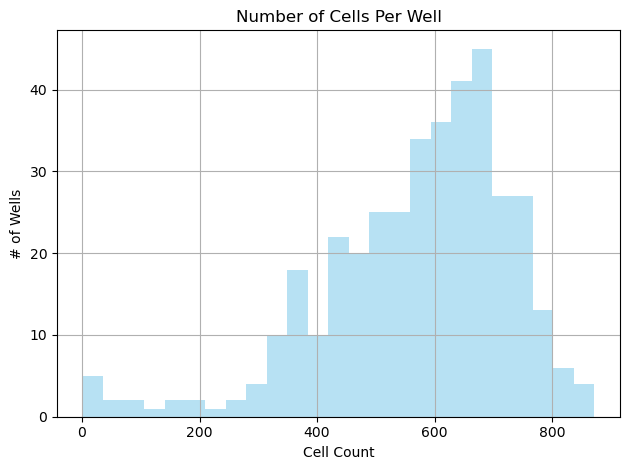

In [35]:
cells_per_well.hist(column=['Number_of_Cells'], bins=25, grid=True, alpha=0.6, color='skyblue')
plt.title('Number of Cells Per Well')
plt.xlabel('Cell Count')
plt.ylabel('# of Wells')
plt.tight_layout()
plt.show()

## Annotated Well Statistics

In [43]:
# view the plate and compound information for plate 24278
biomorph_24278 = biomorph[biomorph.PlateID == 24278]
biomorph_24278

,PlateID,WellID,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease
103,24278,a03,olmesartan medoxomil,SA59556,0,0,0,0,0,0,0,0,0
104,24278,a06,citropten,SA59278,0,0,0,0,0,0,1,0,0
105,24278,a09,bromperidol,SA83338,0,0,0,0,0,0,0,0,0
106,24278,a10,leflunomide,SA792771,1,1,0,1,1,0,0,1,0
107,24278,a11,suxibuzone,SA58544,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,24278,p13,chlorpropamide,SA58227,0,0,0,0,0,0,0,0,0
198,24278,p14,nicorandil,SA83824,0,0,0,0,0,0,0,0,0
199,24278,p17,prednisolone,SA83046,0,0,0,0,0,0,0,0,0
200,24278,p21,chlorzoxazone,SA82767,0,0,0,0,0,0,0,0,0


In [45]:
# add the cell counts for each well
biomorph_24278 = biomorph_24278.merge(cells_per_well, on='WellID', how='left')
biomorph_24278 = move_column(df=biomorph_24278, col_name='Number_of_Cells', new_position=2)
biomorph_24278

,PlateID,WellID,Number_of_Cells,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,microtubule up,mitochondrial disruption up,oxidative stress up,proliferation decrease
0,24278,a03,434,olmesartan medoxomil,SA59556,0,0,0,0,0,0,0,0,0
1,24278,a06,372,citropten,SA59278,0,0,0,0,0,0,1,0,0
2,24278,a09,418,bromperidol,SA83338,0,0,0,0,0,0,0,0,0
3,24278,a10,358,leflunomide,SA792771,1,1,0,1,1,0,0,1,0
4,24278,a11,384,suxibuzone,SA58544,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,24278,p13,366,chlorpropamide,SA58227,0,0,0,0,0,0,0,0,0
95,24278,p14,450,nicorandil,SA83824,0,0,0,0,0,0,0,0,0
96,24278,p17,442,prednisolone,SA83046,0,0,0,0,0,0,0,0,0
97,24278,p21,435,chlorzoxazone,SA82767,0,0,0,0,0,0,0,0,0


In [98]:
# calculate the aggregated cell and nuclei metrics per well
cell_agg_per_well = tableDataframes['Cells'].groupby('WellID').agg(Cells_AreaShape_Area_Mean=('Cells_AreaShape_Area', 'mean'),
                                               Cells_AreaShape_Area_Std=('Cells_AreaShape_Area', 'std'),
                                               Cells_AreaShape_Compactness_Mean=('Cells_AreaShape_Compactness', 'mean'),
                                               Cells_AreaShape_Compactness_Std=('Cells_AreaShape_Compactness', 'std')).reset_index()

nuclei_agg_per_well = tableDataframes['Nuclei'].groupby('WellID').agg(Nuclei_AreaShape_Area_Mean=('Nuclei_AreaShape_Area', 'mean'),
                                                                      Nuclei_AreaShape_Area_Std=('Nuclei_AreaShape_Area', 'std'),
                                                                      Nuclei_AreaShape_Compactness_Mean=('Nuclei_AreaShape_Compactness', 'mean'),
                                                                      Nuclei_AreaShape_Compactness_Std=('Nuclei_AreaShape_Compactness', 'std')).reset_index()

# merge aggregated metrics with the biomorph endpoints table
biomorph_24278 = biomorph_24278.merge(cell_agg_per_well, on='WellID', how='left')
biomorph_24278 = biomorph_24278.merge(nuclei_agg_per_well, on='WellID', how='left')
biomorph_24278

,PlateID,WellID,Number_of_Cells,CPD_NAME,CPD_SAMPLE_ID,apoptosis up,cytotoxicity BLA,cytotoxicity SRB,ER stress,heat shock,...,oxidative stress up,proliferation decrease,Cells_AreaShape_Area_Mean,Cells_AreaShape_Area_Std,Cells_AreaShape_Compactness_Mean,Cells_AreaShape_Compactness_Std,Nuclei_AreaShape_Area_Mean,Nuclei_AreaShape_Area_Std,Nuclei_AreaShape_Compactness_Mean,Nuclei_AreaShape_Compactness_Std
0,24278,a03,434,olmesartan medoxomil,SA59556,0,0,0,0,0,...,0,0,3025.000000,1890.183496,1.459713,0.428609,790.470046,334.425688,1.131536,0.118177
1,24278,a06,372,citropten,SA59278,0,0,0,0,0,...,0,0,3257.204301,1558.891076,1.391748,0.345559,790.475806,276.203911,1.121453,0.106254
2,24278,a09,418,bromperidol,SA83338,0,0,0,0,0,...,0,0,3268.416268,1695.390393,1.362044,0.317074,855.466507,348.382394,1.118604,0.103815
3,24278,a10,358,leflunomide,SA792771,1,1,0,1,1,...,1,0,3486.220670,2165.978982,1.426557,0.438336,803.310056,289.066820,1.133697,0.117365
4,24278,a11,384,suxibuzone,SA58544,0,0,0,0,0,...,0,0,3337.013021,1546.629212,1.396167,0.370439,843.835938,350.746606,1.121310,0.106165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,24278,p13,366,chlorpropamide,SA58227,0,0,0,0,0,...,0,0,3664.437158,1752.410063,1.337976,0.288147,918.560109,340.381584,1.109890,0.106918
95,24278,p14,450,nicorandil,SA83824,0,0,0,0,0,...,0,0,3211.166667,1546.013144,1.360326,0.292102,820.564444,284.928853,1.116666,0.090908
96,24278,p17,442,prednisolone,SA83046,0,0,0,0,0,...,0,0,3516.056561,1534.769224,1.381552,0.297788,857.671946,288.973731,1.135081,0.112933
97,24278,p21,435,chlorzoxazone,SA82767,0,0,0,0,0,...,0,0,3356.245977,1977.914919,1.356307,0.350329,873.889655,322.530914,1.117032,0.102969


## Cell Positioning Inside Well Pictures

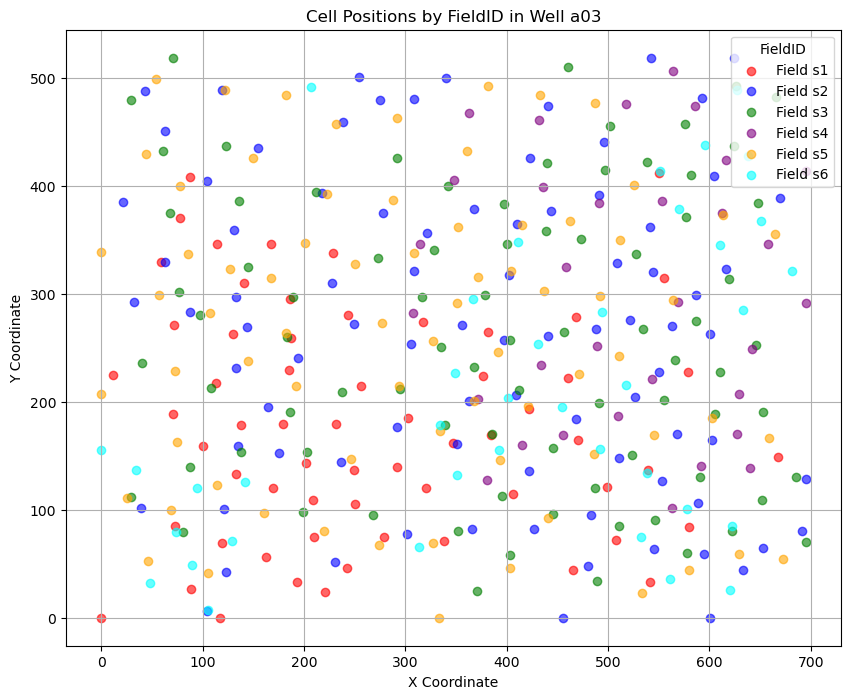

In [103]:
# copy a sample dataframe to view a snippet of cell positions
test = tableDataframes['Cells'][tableDataframes['Cells'].WellID == 'a06']

# define colors for each FieldID
field_colors = {
    's1': 'red',
    's2': 'blue',
    's3': 'green',
    's4': 'purple',
    's5': 'orange',
    's6': 'cyan'
}

plt.figure(figsize=(10, 8))

# plot each FieldID group separately
for field_id, color in field_colors.items():
    # filter cells for the current FieldID
    field_data = test[test['FieldID'] == field_id]
    # plot the cells for this FieldID
    plt.scatter(field_data['Cells_AreaShape_Center_X'], field_data['Cells_AreaShape_Center_Y'], label=f'Field {field_id}', color=color, alpha=0.6)


# label the axes and add a legend
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Cell Positions by FieldID in Well a03')
plt.legend(title='FieldID')
plt.grid(True)
plt.show()

## Endpoint Hit Counts of Well Samples

In [119]:
print(f'Number of plates with endpoint annotation: {len(biomorph['PlateID'].unique())}')
print(f'Number of compounds with endpoint annotation: {len(biomorph['CPD_NAME'].unique())}\n')

# number of unique compounds and compound occurrence counts
compound_occurrence = biomorph['CPD_NAME'].value_counts()
print(f'Compound occurrence counts:\n{compound_occurrence}')

Number of plates with endpoint annotation: 94
Number of compounds with endpoint annotation: 603

Compound occurrence counts:
CPD_NAME
propranolol            24
anabasine              24
timolol                24
bucladesine            23
sulpiride              23
                       ..
dobutamine              4
adenosine               4
1,10-phenanthroline     4
amiodarone              4
cefazolin               4
Name: count, Length: 603, dtype: int64


In [120]:
# create a column with total endpoint sum
biomorph['total_endpoints'] = biomorph[endpoint_columns].sum(axis=1)

# filter out the samples with singular endpoint activity
# biomorph[biomorph['total_endpoints'] > 1]

print(f"The number of samples with no endpoint activity: {biomorph[biomorph['total_endpoints'] == 0].shape[0]}")
print(f"The number of samples with a singular endpoint activity: {biomorph[biomorph['total_endpoints'] == 1].shape[0]}")
print(f"The number of samples with a multiple endpoint activities: {biomorph[biomorph['total_endpoints'] > 1].shape[0]}")

The number of samples with no endpoint activity: 2942
The number of samples with a singular endpoint activity: 868
The number of samples with a multiple endpoint activities: 1215


In [131]:
# add a column with a tuple list of total endpoint activities
biomorph['endpoint_combination'] = biomorph[endpoint_columns].apply(tuple, axis=1)

# retrieve the occurrence counts of endpoint activities
endpoint_combination_counts = biomorph['endpoint_combination'].value_counts()

# group by endpoint combination and then count unique compounds in each group
endpoint_compound_counts = biomorph.groupby('endpoint_combination')['CPD_NAME'].nunique()
endpoint_compound_counts = endpoint_compound_counts.sort_values(ascending=False)

print(f'Endpoint Combination Counts:\n{endpoint_combination_counts}\n')
print(f'Endpoint Compound Counts:\n{endpoint_compound_counts}')

Endpoint Combination Counts:
endpoint_combination
(0, 0, 0, 0, 0, 0, 0, 0, 0)    2942
(1, 0, 0, 0, 0, 0, 0, 0, 0)     317
(0, 1, 0, 0, 0, 0, 0, 0, 0)     281
(0, 0, 0, 0, 0, 0, 0, 1, 0)     118
(1, 1, 0, 0, 0, 0, 0, 0, 0)     117
                               ... 
(0, 0, 0, 1, 1, 0, 1, 1, 1)       8
(1, 0, 0, 0, 0, 1, 1, 1, 1)       8
(1, 0, 1, 0, 0, 0, 0, 0, 0)       8
(1, 0, 1, 0, 1, 0, 0, 1, 1)       8
(1, 1, 0, 1, 1, 0, 1, 0, 1)       4
Name: count, Length: 79, dtype: int64

Endpoint Compound Counts:
endpoint_combination
(0, 0, 0, 0, 0, 0, 0, 0, 0)    350
(1, 0, 0, 0, 0, 0, 0, 0, 0)     41
(0, 1, 0, 0, 0, 0, 0, 0, 0)     33
(0, 0, 0, 0, 0, 0, 0, 1, 0)     14
(1, 1, 0, 0, 0, 0, 0, 0, 0)     14
                              ... 
(1, 0, 1, 0, 0, 0, 0, 1, 1)      1
(0, 0, 1, 1, 0, 1, 1, 1, 1)      1
(1, 0, 1, 0, 1, 0, 0, 1, 1)      1
(0, 0, 1, 1, 0, 0, 1, 1, 1)      1
(0, 1, 1, 1, 1, 0, 0, 0, 1)      1
Name: CPD_NAME, Length: 79, dtype: int64


### (Ola) "Understanding what compounds group into which groups"?

- **Is there a way to extract information from just the distribution of compound samples?**

### Linking Compound Groupings with Phenotypic(endpoints?) and Spatial Information
- Endpoint combination counts for each compound (this way because endpoints combinations are around 80 and compounds are around 600)
    - "For each compound type (mostly the heavily occuring ones) what are the most common endpoint combinations?"
- For each compound: number of cells (?), mean cell area, variance of cell area, mean and variance of *Cells_AreaShape_Compactness*, and the density of the cells (i.e. the size of the neighborhood)(will be searched through Summer et al., 2022)